# Classifying Representatives as Democrats or Republicans

## Data 

### Data Description 

The dataset contains a partial voting record in the U.S. House of Representatives from the year 1984. For each of the 435 Representatives, and each of 16 votes that were taken in the House, the dataset tells us whether the Representative voted Yes, voted No, or abstained (this is a simplification: there are more possibilities in reality) on the particular issue. It also indicates whether the Representative is a Democrat or Republican. Hence, it is natural to use this data to try and predict party affiliation from voting behavior. 

### Acknowledgment of Data Sources

The dataset is downloaded from Kaggle:
https://www.kaggle.com/devvret/congressional-voting-records

The original source of the data is stated as:

Congressional Quarterly Almanac, 98th Congress, 2nd session 1984, Volume XL: Congressional Quarterly Inc. Washington, D.C., 1985.
https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records

and the following citation is given: 

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.



## Preliminaries

Load relevant libraries, and read in the dataset.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [2]:
df=pd.read_csv("house-votes-84.csv")

In [3]:
print(df.shape)
print(df.columns)
print(df[" el-salvador-aid"].value_counts())
print(df.isnull().sum().sum())

(435, 17)
Index(['Class Name', ' handicapped-infants', ' water-project-cost-sharing',
       ' adoption-of-the-budget-resolution', ' physician-fee-freeze',
       ' el-salvador-aid', ' religious-groups-in-schools',
       ' anti-satellite-test-ban', ' aid-to-nicaraguan-contras', ' mx-missile',
       ' immigration', ' synfuels-corporation-cutback', ' education-spending',
       ' superfund-right-to-sue', ' crime', ' duty-free-exports',
       ' export-administration-act-south-africa'],
      dtype='object')
y    212
n    208
?     15
Name:  el-salvador-aid, dtype: int64
0


Each row corresponds to one of 435 Representatives. The first column indicates the label (Democrat or Republican), and then there are 16 feature columns each of which correspond to an issue that was voted on. Each representative's vote is recorded as Yes, No, or a question mark (which we take to mean abstention or absence). No values are missing from the dataframe. 

Start by renaming the columns so as to make the table more readable.

In [4]:
dict01={" handicapped-infants":"Handicap"," water-project-cost-sharing":"Water Project",
       " adoption-of-the-budget-resolution":"Budget"," physician-fee-freeze":"Physicians", " el-salvador-aid":"El Salvador",
       " religious-groups-in-schools":"Religion", " anti-satellite-test-ban":"Satellites"," aid-to-nicaraguan-contras":"Nicaragua",
       " mx-missile":"MX"," immigration":"Immigration"," synfuels-corporation-cutback":"Synfuels"," education-spending":"Educ",
       " superfund-right-to-sue":"Superfund"," crime":"Crime"," duty-free-exports":"Dutyfree",
        " export-administration-act-south-africa":"South Africa"}

df=df.rename(columns=dict01)


Now we assign numerical values to the representatives' votes: We will use +1 for a Yes-vote and -1 for a No-Vote, with 0 for an abstention or absence. Since abstention can be suitably interpreted as something "in between" a Yes-vote and a No-vote, it seems adequate to represent the votes by numerical data. 

In [5]:
dict02={"y":1, "?":0, "n":-1, "republican":"R", "democrat":"D"}
df=df.replace(dict02)

Suppose we want to predict the label (Democrat or Republican) from the features (how the representative voted on each of the 16 issues). One first attempt at classification could be to check how well a particular issue divided the House along party lines.
To this end, create a "polarization score" for each issue as follows: Compute how the "average Democrat" voted on the issue. For instance, suppose there are 10 democrats: 7 vote in favor, 2 vote against, and one abstains. Then we can express the average Democrat support for the issue with the number (7x(+1) + 2x(-1) + 1x(0))/10 = +0.5. We can compute the analoguous measure for the Republicans, and then consider half of the squared difference between the two, times one hundred, as the **polarization score.** Squaring is done so that the score measures only the size of the difference between Democrats and Republicans, rather than the direction of the difference. Initial division by two and eventual multiplication by 100 is done so that the polarization score lies between 0 and 100. A score of 0 means that an issue has equal support among Democrats and Republicans. A score of 100 means that all Democrats were in favor, and all Republicans against, or the reverse. 

Let's now create a table that shows the polarization score for each issue. 

In [6]:
def average_democrat(issue, vc=False):
    dems_only=df[df["Class Name"]=="D"]
    if vc==True:
        print(dems_only[issue].value_counts())    
    number=len(dems_only)
    addition=dems_only[issue].sum()
    return addition/number

def average_republican(issue, vc=False):
    reps_only=df[df["Class Name"]=="R"]
    if vc==True:
        print(reps_only[issue].value_counts()) 
    number=len(reps_only)
    addition=reps_only[issue].sum()
    return addition/number

def polarization_score(issue):
    dem=average_democrat(issue)
    rep=average_republican(issue)
    return (0.5*(dem-rep))**2

In [7]:
issues=list(df.columns.values)
issues=issues[1:]
print(issues)

['Handicap', 'Water Project', 'Budget', 'Physicians', 'El Salvador', 'Religion', 'Satellites', 'Nicaragua', 'MX', 'Immigration', 'Synfuels', 'Educ', 'Superfund', 'Crime', 'Dutyfree', 'South Africa']


In [8]:
polarization={}
for issue in issues:
    polarization[issue]=round(100*polarization_score(issue),2)
pol_table=pd.DataFrame.from_dict(polarization,orient="index",columns=["Polarization Score"])
pol_table=pol_table.sort_values(by="Polarization Score", ascending=False)
print(pol_table)

               Polarization Score
Physicians                  83.13
Budget                      54.08
El Salvador                 51.12
Educ                        45.39
Nicaragua                   42.04
MX                          38.15
Crime                       36.66
Superfund                   28.92
Satellites                  26.42
Dutyfree                    26.03
Religion                    17.25
Handicap                    16.62
Synfuels                    12.52
South Africa                 2.71
Immigration                  0.72
Water Project                0.00


Visualize the polarization scores of each issue in a barplot. 

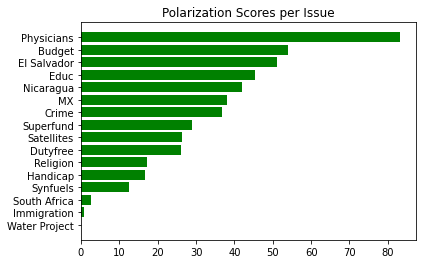

In [9]:
plt.barh(range(len(pol_table)),pol_table["Polarization Score"],tick_label=pol_table.index,color="green")
plt.gca().invert_yaxis()
plt.title("Polarization Scores per Issue")
plt.show()


Take a closer look at the most polarized and least polarized issues, starting with the "Water Project."

In [10]:
average_democrat("Water Project",vc=True)
average_republican("Water Project",vc=True)

 1    120
-1    119
 0     28
Name: Water Project, dtype: int64
 1    75
-1    73
 0    20
Name: Water Project, dtype: int64


0.011904761904761904

Indeed, we see that Democrats as well as Republicans are almost evenly split on the "Water Project." Hence, polarization along partly lines is very low.

Now, look at the issue with the highest polarization score: "Physicians"

In [11]:
average_democrat("Physicians",vc=True)
average_republican("Physicians",vc=True)

-1    245
 1     14
 0      8
Name: Physicians, dtype: int64
 1    163
 0      3
-1      2
Name: Physicians, dtype: int64


0.9583333333333334

Here, we see the reverse: Democrats vote 245:14 against, while Republicans vote 163:2 in favor. Each party is quite united, and the House split along party lines, leading to the high polarization score. 

If we were to classify Representatives according to how they voted on the "Physicians" issue, then we would misclassify 16 of them, and we would not know what to do with an additional 11. Instead of looking at the most polarized issue in isolation, we will now use Random Forest classifier to distinguish between Democrats and Republicans based on their voting record. 

## Classification with a Random Forest

Let us now see how well a Random Forest Classifier can distinguish between Democrats and Republicans. We split the representatives into a train set and a test set in a proportion of 3:1, and generate predictions using Sci-Kit-Learn's Random Forest Classifier. 

In [12]:
cols=list(df)
feature_cols=cols[1:]
#feature_cols.remove("Physicians")
v=df["Class Name"]
M=df[feature_cols]

In [13]:
M_train, M_test, v_train, v_test = train_test_split(M, v, test_size=0.25, random_state=0)

rfc = RandomForestClassifier()
rfc.fit(M_train, v_train)
random_forest_predictions = rfc.predict(M_test)

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


To assess performance of the Random Forest Classifier, create a confusion matrix and compute the accuracy score.

In [14]:
random_forest_score = rfc.score(M_test, v_test)
random_forest_confusion_matrix = confusion_matrix(v_test, random_forest_predictions)
random_forest_confusion_matrix_df = pd.DataFrame(random_forest_confusion_matrix, columns=["D","R"],index=["D","R"])

In [15]:
def heatmap(cm, cmap):
    sns.heatmap(cm, annot=True, annot_kws={"size": 25}, cmap=cmap, cbar=False, fmt="g", linecolor=
                        "black", linewidths=1)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

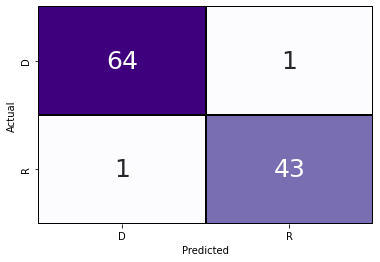

98.17% of Representatives in the test set are correctly predicted by the Random Forest.


In [16]:
heatmap(random_forest_confusion_matrix_df, "Purples")
print(str(round(random_forest_score*100,2))+"% of Representatives in the test set are correctly predicted by the Random Forest.")

Compared to just using the "Physicians" issue for classification, the Random Forest classifies representatives more accurately. The purpose in this notebook is to try and explain *how* the Random Forest decides to classify someone as a Democrat or a Republican. The Shapley value is used to obtain this explanation. 

## Introduction to Shapley Values 

### Cooperative Game Theory 

Shapley Values are an important concept in *Cooperative Game Theory.* Loosely speaking, their purpose is to provide a measure for how much each party contributes to a joint effort.

To give a highly stylized example, let's say that there are three individuals (A, B, and C). Each of them could earn an income of 40,000 euros by working on a freelance basis. Instead of freelancing, however, they can also join forces and set up a company together. They can then benefit from the complementarity of their skills. (Maybe A is a great Python developer, and B a great JavaScript developer, and C is a marketing genius.) Let's say that a A and C or B and C together could earn 100,000 euros, and that A and B together could make 90,000. If all three of them join in, then they can even earn 180,000. Now the question is: How should their total profit of 180,000 be divided? One simple way would be to just divide it by 3 so that each gets 60,000. However, person C might object to this because the pairs he can form with A or B are worth more (100,000) than the pair that A and B can form without C (90,000). Thus, we can argue that C is making a greater contribution than A or B and "deserves" a bigger share. This is an example of the consideration that is taken into account by the Shapley Value.

In terms of computation, the Shapley Value can be found as follows:

Let's imagine that we individuals join one by one. Initially, only A is present and so has 40,000. If B joins, then they have 90,000, so we can say that B's "marginal contribution" is 50,000. If C also joins, then they have 180,000 altogether, so C's marginal contribution is 90,000.

Of course, this consideration depends on the order in which players join. Let's try instead the order C-B-A: If C is alone, he has 40,000. If B joins, they have 100,000, so B's marginal contribution is 60,000. Finally, if A joins, they have 180,000 altogether, so that A's marginal contribution is 80,000.

As there are six different ways to order the three individuals, we can find six different vectors of marginal contributions.
They are (in thousands):

ABC: 40/50/90

ACB: 40/80/60

BAC: 50/40/90

BCA: 80/40/60

CAB: 60/80/40

CBA: 80/60/40

The Shapley values are given by the average over these six vectors: (175/3, 175/3, 190/3).
If they divide their profit of 180,000 according to Shapley values, then indeed, C will get 63,333 euros, while A and B only get 58,333 euros each.

How can we use this to explain a classification? 



### Interpretable Machine Learning

In a classification task, each feature pushes the prediction in a certain direction. If one feature were eliminated (in our case, let's imagine that we change a Yes or No vote to an abstention), then the effect of this on the prediction can be interpreted as a marginal contribution. If we eliminate features one after the other, we get marginal contributions for each feature. In the case of a Random Forest classification, these marginal contributions will be order-dependent. Hence, we would come up with the vectors of marginal contributions for each order and then average all of them. That way, we obtain Shapley values that reflect the relative importance of each feature for the prediction that the machine learning model makes. (These Shapley values typically differ across different instances, however: In the example at hand, feature importance need not be the same for each member of the House.


In what follows, I will use the SHAP module which is available from Scott Lundberg's Github, here:
https://github.com/slundberg/shap


## Explaining the Classification using Shapley Values 

I use the SHAP module to obtain an explanation of the Random Forest Classification. The module contains explainers for several kinds of classifiers. Since the Random Forest is tree-based, the TreeExplainer is appropriate to the case at hand. The SHAP module contains a function to generate so-called force plots which shows the relative importance of different features in the classification. On top of this function, let's build a simple command that visualizes the force plot for any given member of the House in our dataset:

In [17]:

RFexplainer = shap.TreeExplainer(rfc, M_train, feature_perturbation="interventional")
shap.initjs()

def make_forceplot_RF(index):
    example=M_test.iloc[[index]]
    shap_values = RFexplainer.shap_values(example)
    shap.force_plot(RFexplainer.expected_value[1],shap_values[1],example,matplotlib=True)
    print("Representative No. "+str(index)+" in the test set is predicted to be "+str(random_forest_predictions[index])+".")
    

Now we can choose representatives (let's say the ones at index positions 100, 22, and 57) and visualize how the Random Forest classified them and why. Notice how feature importance as measured by Shapley values differs across instances. 

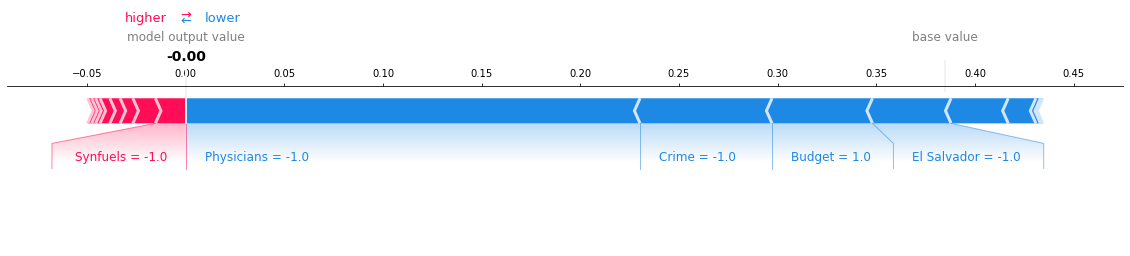

Representative No. 100 in the test set is predicted to be D.


In [18]:
make_forceplot_RF(100)

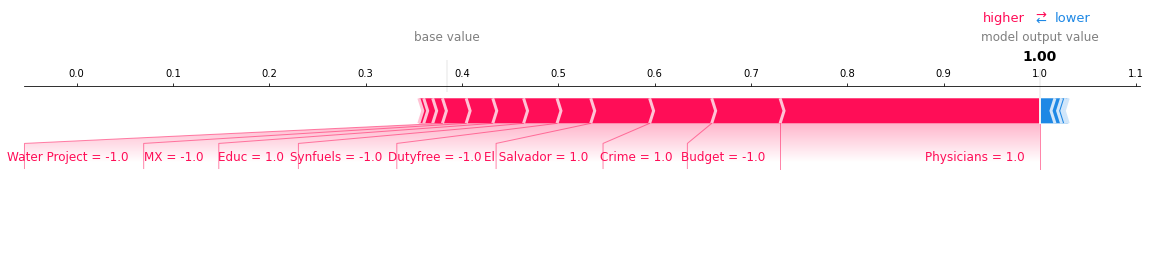

Representative No. 22 in the test set is predicted to be R.


In [19]:
make_forceplot_RF(22)

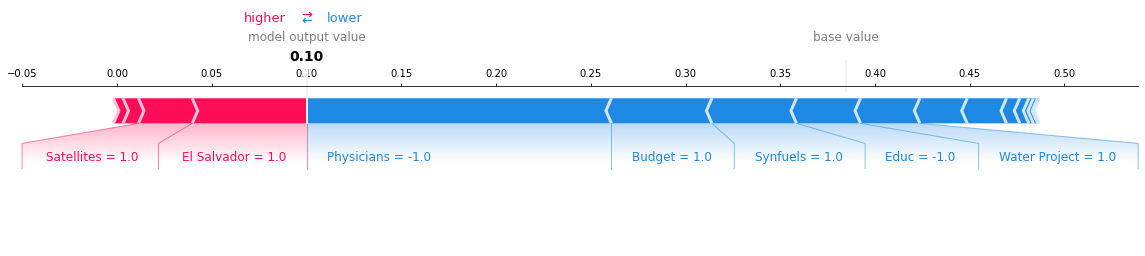

Representative No. 57 in the test set is predicted to be D.


In [20]:
make_forceplot_RF(57)

## Overall feature importance 

Another feature of the SHAP module allows us to summarize how important different features were for the Random Forest classification overall, that is, across all the different representatives. This is called a summary plot. 

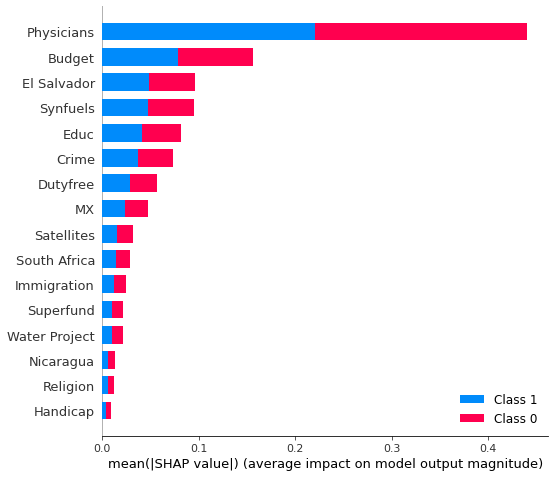

In [21]:
shap.summary_plot(RFexplainer.shap_values(M_test), M_test)

We have seen before that "Physicians" was the most polarized issue in the dataset, and so it is not surprising that is also has the most impact on the classification. Likewise, the "Budget" issue is both very polarized and has a lot of imnpact on the classification. However, it is not always true that more polarized issues had greater impact on the classification: For instance, "Synfuels" is an issue with quite a low polarization score but a lot of impact on the classification. One potential explanation for this discrepancy could be that "Synfuels" is important in distinguishing those representatives which deviate from their party line on "Physicians." Let's see if this is true:

Select those rows from the dataset that refer to representatives which did not vote along party lines on "Physicians."

In [22]:
boolRdiss=(df["Class Name"]=="R")&(df["Physicians"]!=1)
boolDdiss=(df["Class Name"]=="D")&(df["Physicians"]!=-1)

diss=df[(boolDdiss==True)|(boolRdiss==True)]


print(len(diss))

27


There are 27 such dissenters. (I count abstentions as dissent as well.) Only considering the representatives who dissented on "Physicians," we can compute how the average 

In [23]:
av_diss=diss[["Class Name","Synfuels"]].groupby("Class Name").mean()
print(av_diss)

            Synfuels
Class Name          
D           0.590909
R          -0.600000


Now we can look at the polarization score of the "Synfuels" vote only among those representatives who dissented on "Physicians." Using the same formula as before, it is 50 x (0.59+0.6)^2, which is approximately 72.  Indeed, the "Synfuels" issue polarizes those members of the House who dissented from party lines on "Physicians."  